<a href="https://colab.research.google.com/github/matician255/NEURAL-NETWORK-FLASHCARDS/blob/main/pytorch_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline




In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-05-23 10:32:29--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-05-23 10:32:30 (6.73 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for  s, i in stoi.items()}
vocab_size = len(itos)

In [7]:
# 1) Define how many “previous characters” we look at to predict the next one
block_size = 3

# BULDING THE DATASET
def build_dataset(words):



  # 2) Prepare empty lists to hold input contexts (X) and targets (Y)
  X, Y = [], []

  for w in words:
    #print(w)    # (optional) show the word you’re processing

    # 4) Start with a “blank” context of three dots (0 is the index for ‘.’)
    context = [0] * block_size # [0, 0, 0]

    # 5) Walk through each character in the word, plus a trailing “.” to mark its end
    for chr in w + '.':
      ix = stoi[chr]  # look up the integer index for this character

      # 6) Record the current context as one training input
      X.append(context)

      # 7) …and record the “correct next character” as the training target
      Y.append(ix)

      # 8) (Optional) print the example you just built, e.g.:
      #print(''.join(itos[i] for i in context), '--->', itos[ix])

      # 9) Slide the window: drop the oldest char and append the new one
      #    So if context was [., t, e] and ix is 19 (“s”), it becomes [t, e, s]
      context = context[1:] + [ix] # crop and append

  # 10) Once you’ve built all examples, convert your Python lists into tensors
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [8]:
n_embd = 10 # number of dimensionality of the character embedding vector
n_hidden = 200 # number of neurons in the hidden layer of the MLP



g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * vocab_size , n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [10]:


# training a deep neural network

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    # Initializes weights using Xavier/He initialization (1/√fan_in)
    self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5
    # optional bias
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # trainable parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #running statistics (trained with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    #calculte forward pass
    if self.training:
      # Use batch statistics
      xmean = x.mean(0, keepdim=True) #batch mean
      xvar = x.var(0, keepdim=True, unbiased=True) #batch variance

    else:
      # Use running statistics
      xmean = self.running_mean
      xvar = self.running_var

    # Normalize
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
    self.out = self.gamma * xhat + self.beta #scale and shift

    # Update running statistics
    if self.training:
      with torch.no_grad(): # Maintains running averages during training
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1- self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta] # Has learnable parameters: gamma (scale) and beta (shift)

class Tanh:  # Applies the tanh() function to introduce non-linearity
  def __call__(self, x):
    self.out = torch.tanh(x) # Squash to [-1, 1]
    return self.out
  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

c = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  #last layer make less confident
  layers[-1].weight *= 0.1
  #all other layers apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3  # He initialization gain for Tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # numbers of parameters in total
for p in parameters:
  p.requires_grad = True


47497


In [20]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []


for i in range(max_steps):
  #mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
  #Forward pass
  emb = C[Xb] #embed the characters into vectors
  x = emb.view(emb.shape[0], -1) #concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) #loss function

  #backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #tracks stats
  if i % 1000 == 0: #print every once in a while
    print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])




      0 /  200000: 2.0789
   1000 /  200000: 2.6665
   2000 /  200000: 1.8392
   3000 /  200000: 2.2418
   4000 /  200000: 2.1601
   5000 /  200000: 2.2395
   6000 /  200000: 1.6088
   7000 /  200000: 2.1576
   8000 /  200000: 1.7972
   9000 /  200000: 1.7721
  10000 /  200000: 1.9565
  11000 /  200000: 1.9126
  12000 /  200000: 2.0709
  13000 /  200000: 2.5369
  14000 /  200000: 2.6567
  15000 /  200000: 2.1029
  16000 /  200000: 2.2731
  17000 /  200000: 2.5176
  18000 /  200000: 2.0274
  19000 /  200000: 2.0608
  20000 /  200000: 2.0601
  21000 /  200000: 2.2021
  22000 /  200000: 2.3272
  23000 /  200000: 2.4616
  24000 /  200000: 2.1738
  25000 /  200000: 1.9900
  26000 /  200000: 1.8953
  27000 /  200000: 1.9011
  28000 /  200000: 1.9359
  29000 /  200000: 2.0707
  30000 /  200000: 1.8981
  31000 /  200000: 1.9504
  32000 /  200000: 1.9359
  33000 /  200000: 2.0441
  34000 /  200000: 1.8023
  35000 /  200000: 2.1817
  36000 /  200000: 2.1019
  37000 /  200000: 1.9922
  38000 /  2

layer 2 (      Tanh): mean -0.01, std 0.70, saturated: 13.34%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 16.06%
layer 8 (      Tanh): mean +0.02, std 0.75, saturated: 16.00%
layer 11 (      Tanh): mean +0.00, std 0.77, saturated: 18.38%
layer 14 (      Tanh): mean +0.02, std 0.60, saturated: 6.66%


Text(0.5, 1.0, 'activation distribution')

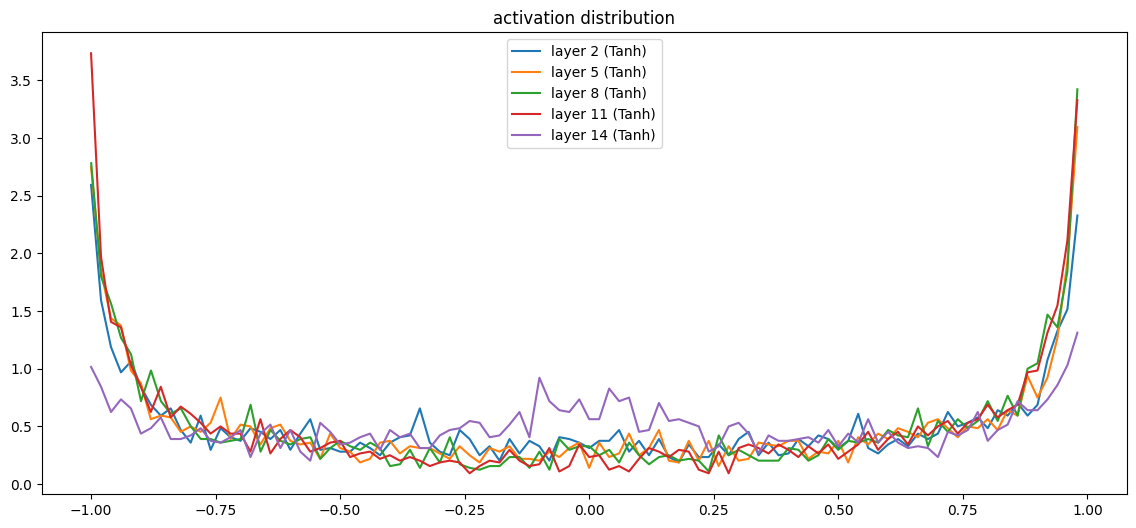

In [15]:
#visualize histogram
plt.figure(figsize=(14, 6)) # width and height of the plot
legends = [] # Stores labels for the legend
for i, layer in enumerate(layers[:-1]): #note exclude the outpt layer
  if isinstance(layer, Tanh): # Focus only on Tanh layers
    t = layer.out # Activation values after Tanh

    # Mean/Std: Measures if activations are centered (mean ≈ 0) and scaled (std ≈ 1)
    # Saturation: Percentage of activations near ±1 (values with |t| > 0.97).
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True) # Bins and frequencies
    plt.plot(hx[:-1].detach(), hy.detach())  # Plot bin centers vs frequencies
    # hx[:-1]: Use bin centers (excluding the last edge) for alignment.
    # .detach(): Converts tensors to numpy arrays for plotting.

    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')


layer 2 (      Tanh): mean +0.000000, std 4.028516e-03
layer 5 (      Tanh): mean +0.000000, std 4.145497e-03
layer 8 (      Tanh): mean +0.000000, std 4.070280e-03
layer 11 (      Tanh): mean +0.000000, std 3.872302e-03
layer 14 (      Tanh): mean -0.000034, std 5.575546e-03


Text(0.5, 1.0, 'gradient distribution')

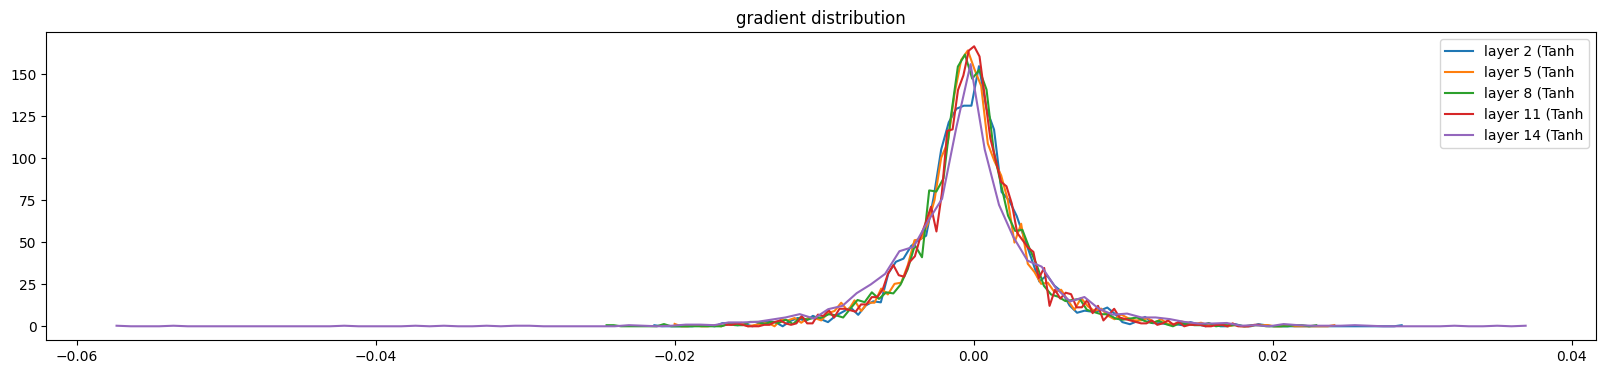

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad # get the gradients of the layer
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.403514e-02 | grad:data ratio 1.271924e-02
weight  (30, 100) | mean +0.000084 | std 8.707901e-03 | grad:data ratio 2.137970e-02
weight (100, 100) | mean +0.000023 | std 5.993096e-03 | grad:data ratio 2.425779e-02
weight (100, 100) | mean -0.000017 | std 6.029975e-03 | grad:data ratio 2.471349e-02
weight (100, 100) | mean -0.000022 | std 5.973753e-03 | grad:data ratio 2.460684e-02
weight (100, 100) | mean -0.000062 | std 5.346188e-03 | grad:data ratio 2.225703e-02
weight  (100, 27) | mean -0.000000 | std 1.604528e-02 | grad:data ratio 6.926508e-02


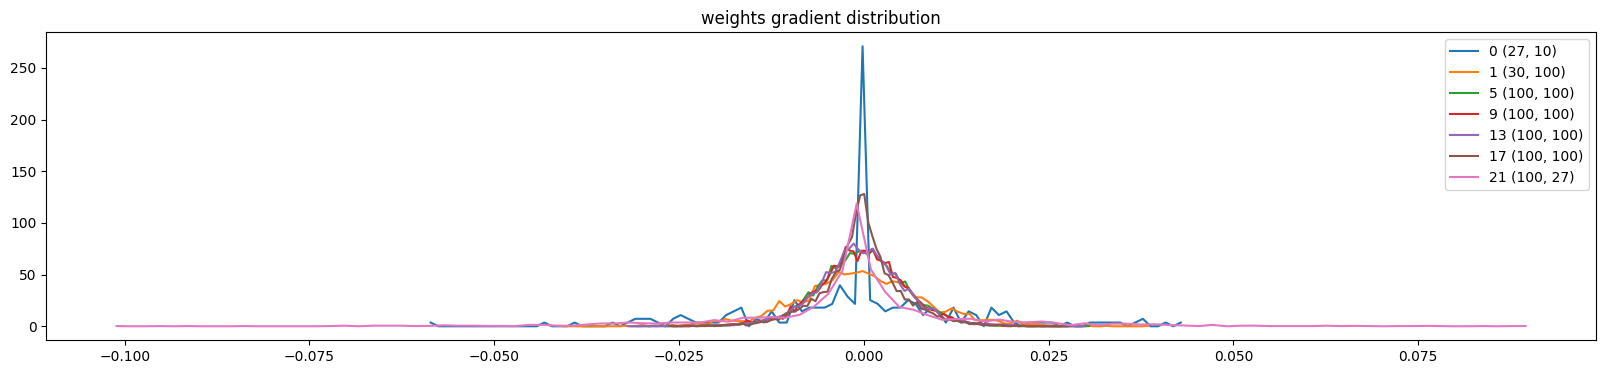

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'parameters distribution')

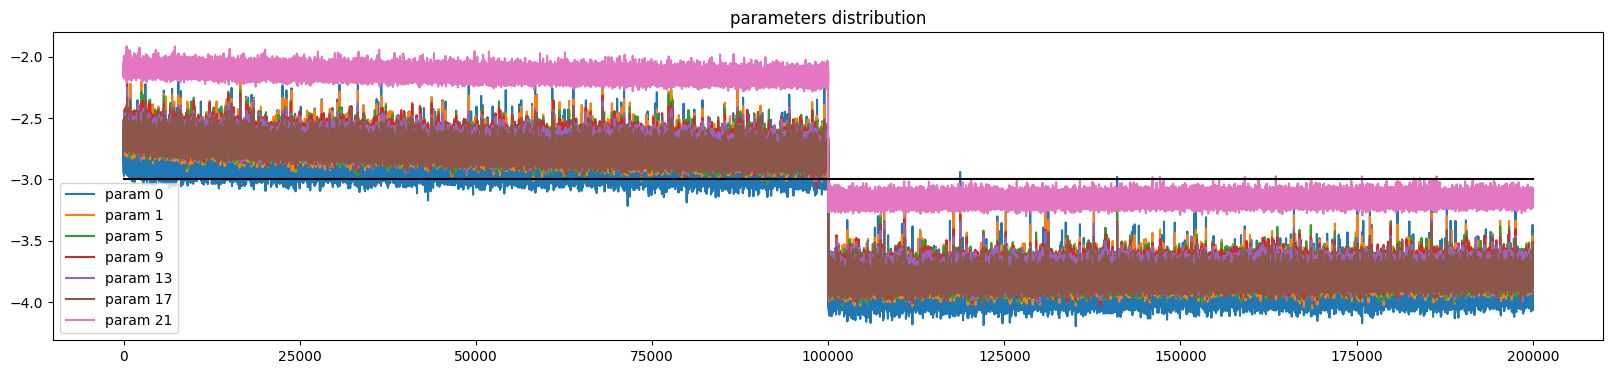

In [21]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j] [i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 indicate on plot
plt.legend(legends)
plt.title('parameters distribution')


In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9869976043701172
val 2.081280469894409


In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
seel.
nihaham.
reisha.
endraegan.
chediel.
izell.
jenne.
elisson.
arleigh.
malaia.
noshubergiagriel.
kindreed.
konnie.
casubakard.
rhylene.
els.
kayshayveona.
halisa.
yansun.
